### Modeling Basketball Scores

The goal of this notebook is to create a model that can predict the scores of basketball games given each teams' offensive and defensive abilities and home advantage. In the future, I hope to also incorporate other factors such as

1. Individual players offensive and defensive abilities
2. Number of days of rest since last game
3. Distance traveled since last game

### Model Description

In this notebook, I use two types of models that I call the multiplicative model and the additive model. The names are based on how the parameters are combined to predict scores. Given the following definitions:

Home team offensive parameter: $m_h$ <br>
Home team defensive parameter: $n_h$ <br>
Away team offensive parameter: $m_a$ <br>
Away team defensive parameter: $n_a$ <br>
Home advantage parameter: $h$

the predicted points scored by the home and away teams will be

**Multiplicative model**<br>
Home points = $m_h  n_a  h$ <br>
Away points = $\frac{m_a  n_h}{h}$ <br>

**Additive model**<br>
Home points = $m_h + n_a + h$ <br>
Away points = $m_a + n_h - h$

If a game is played at a neutral venue, then $h$ is removed from each equation.

Both models are relatively simple. As will be shown below, they can do a solid job of predicting which teams will rise to the top or sink to the bottom after playing many games, but it does not account for the factors that lead to game-to-game variability. To some extent, that variability cannot be modeled because player performance can change unpredictably, but I do think that a model that accounts for factors like individual player strengths, rest, and travel could outperform the simpler models presented here.

### Fitting a Model



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
games = pd.read_excel('games.xlsx')
games

,date,time,away_team,away_score,home_team,home_score,ot,attendance,arena
0,Tue Oct 18 2022,7:30p,Philadelphia 76ers,117,Boston Celtics,126,NaN,19156.0,TD Garden
1,Tue Oct 18 2022,10:00p,Los Angeles Lakers,109,Golden State Warriors,123,NaN,18064.0,Chase Center
2,Wed Oct 19 2022,7:00p,Orlando Magic,109,Detroit Pistons,113,NaN,20190.0,Little Caesars Arena
3,Wed Oct 19 2022,7:00p,Washington Wizards,114,Indiana Pacers,107,NaN,15027.0,Gainbridge Fieldhouse
4,Wed Oct 19 2022,7:30p,Houston Rockets,107,Atlanta Hawks,117,NaN,17878.0,State Farm Arena
...,...,...,...,...,...,...,...,...,...
1225,Sun Apr 9 2023,3:30p,Utah Jazz,117,Los Angeles Lakers,128,NaN,18997.0,Crypto.com Arena
1226,Sun Apr 9 2023,3:30p,New Orleans Pelicans,108,Minnesota Timberwolves,113,NaN,18978.0,Target Center
1227,Sun Apr 9 2023,3:30p,Memphis Grizzlies,100,Oklahoma City Thunder,115,NaN,16601.0,Paycom Center
1228,Sun Apr 9 2023,3:30p,Los Angeles Clippers,119,Phoenix Suns,114,NaN,17071.0,Footprint Center


In [3]:
# Change ot column to count number of overtimes
games["ot"].replace({pd.NA:0, "OT":1, "2OT":2, "3OT":3, "4OT":4, "5OT":5, "6OT":6}, inplace=True)

In [4]:
games

,date,time,away_team,away_score,home_team,home_score,ot,attendance,arena
0,Tue Oct 18 2022,7:30p,Philadelphia 76ers,117,Boston Celtics,126,0,19156.0,TD Garden
1,Tue Oct 18 2022,10:00p,Los Angeles Lakers,109,Golden State Warriors,123,0,18064.0,Chase Center
2,Wed Oct 19 2022,7:00p,Orlando Magic,109,Detroit Pistons,113,0,20190.0,Little Caesars Arena
3,Wed Oct 19 2022,7:00p,Washington Wizards,114,Indiana Pacers,107,0,15027.0,Gainbridge Fieldhouse
4,Wed Oct 19 2022,7:30p,Houston Rockets,107,Atlanta Hawks,117,0,17878.0,State Farm Arena
...,...,...,...,...,...,...,...,...,...
1225,Sun Apr 9 2023,3:30p,Utah Jazz,117,Los Angeles Lakers,128,0,18997.0,Crypto.com Arena
1226,Sun Apr 9 2023,3:30p,New Orleans Pelicans,108,Minnesota Timberwolves,113,0,18978.0,Target Center
1227,Sun Apr 9 2023,3:30p,Memphis Grizzlies,100,Oklahoma City Thunder,115,0,16601.0,Paycom Center
1228,Sun Apr 9 2023,3:30p,Los Angeles Clippers,119,Phoenix Suns,114,0,17071.0,Footprint Center


In [32]:
# Function for fitting parameters for offense, defense, and home advantage.
def fit_parameters(game_data,
                   column_names=['home_team','home_score','away_score','away_team','ot','neutral'],
                   model_type='mult',
                   reg_time=48,
                   ot_time=5,
                   no_neutral=True,
                   delta_thresh=1e-7):
    """
    This function takes in scores of games and calculates parameters for offense,
    defense, and home advantage iteratively.
    
    Input:
    game_data: A Pandas DataFrame that contains columns representing teams, scores,
    whether or not the game was played at a neutral location, and the number of overtimes.
    
    column_names: Defines the names of the columns that correspond to each necessary feature.
    The default column_names are:
        home_team: Home team. Can be name or numerical identifier.
        home_score: Score for home team.
        away_score: Score for away team.
        away_team: Away team. Can be name or numerical identifier.
        ot: Number of overtimes played.
        neutral: 1 if the game was played at a neutral location. 0 if not.
    The DataFrame can contain other columns and the order does not matter.
    
    model_type: Type of model to use. Options are:
        mult: Multiplicative model that calculates home score as
            (home offense)*(away defense)*(home advantage)
            and calculates away score as
            (away offense)*(home defense)/(home advantage)
        add: Additive model that calculates home score as
            (home offense) + (away defense) + (home advantage)
            and calculates away score as
            (away offense) + (home defense) - (home advantage)
    
    reg_time: Number of minutes in a regulation game. Default is 48 (NBA length).
    
    ot_time: Number of minutes in an overtime. Default is 5.
    
    no_neutral: Specifies if none of the gamees were at a neutral location. Default is True.
    
    delta_thresh: In order for the iterative fitting of parameters to stop, all changes must
    be below the delta_thresh. Default is 1e-5.
    
    Output:
    A dictionary that has one entry for each team that includes offense and defense
    parameters and one entry for home advantage.
    """
    # Make copy of games_data DataFrame
    game_copy = game_data.copy()
    
    # Get the necessary column names
    h_team, h_score, a_score, a_team, ot, neutral = column_names
    
    # Get list of unique teams
    teams = np.sort(game_copy[h_team].unique())
    
    # Turn team names into numerical IDs
    team_dict = {team: num for num, team in enumerate(teams)}
    game_copy.replace(team_dict, inplace=True)
    
    # Get total points scored and allowed for each team
    pts_scored = np.array([np.sum(game_copy.loc[game_copy[a_team]==team,a_score]) + \
                           np.sum(game_copy.loc[game_copy[h_team]==team,h_score]) for team in team_dict.values()])
    pts_allowed = np.array([np.sum(game_copy.loc[game_copy[a_team]==team,h_score]) + \
                            np.sum(game_copy.loc[game_copy[h_team]==team,a_score]) for team in team_dict.values()])
    
    # Get total home points and total away points by all teams
    if no_neutral:
        home_total = np.sum(game_copy[h_score])
        away_total = np.sum(game_copy[a_score])
    else:
        home_total = np.sum(game_copy.loc[game_copy[neutral]==0,h_score])
        away_total = np.sum(game_copy.loc[game_copy[neutral]==0,a_score])
        
    # Calculate number of games each team played
    n_games = [np.sum(game_copy[a_team]==team) + np.sum(game_copy[h_team]==team) for team in team_dict.values()]
        
    # Multiplicative model
    if model_type == 'mult':
        # Initialize the parameters
        off_par = np.sqrt([pts / ng for team, pts, ng in zip(team_dict.values(), pts_scored, n_games)])
        
        def_par = np.sqrt([pts / ng for team, pts, ng in zip(team_dict.values(), pts_allowed, n_games)])
        
        h_adv = 1.0
        
        end_loop = 0
        # Create variable to track which parameter is changing
        off_def_adv = 0
        while end_loop < 3:
            # Use model to calculate scores for each game
            if no_neutral:
                game_copy[a_score] = off_par[game_copy[a_team]] * def_par[game_copy[h_team]] / h_adv * \
                (1.0 + game_copy['ot']*ot_time/reg_time)
                game_copy[h_score] = off_par[game_copy[h_team]] * def_par[game_copy[a_team]] * h_adv * \
                (1.0 + game_copy['ot']*ot_time/reg_time)
            else:
                game_copy[a_score] = off_par[game_copy[a_team]] * def_par[game_copy[h_team]] / \
                np.array([1.0 if neut==1 else h_adv for neut in game_copy[neutral]]) * \
                (1.0 + game_copy['ot']*ot_time/reg_time)
                game_copy[h_score] = off_par[game_copy[h_team]] * def_par[game_copy[a_team]] * \
                np.array([1.0 if neut==1 else h_adv for neut in game_copy[neutral]]) * \
                (1.0 + game_copy['ot']*ot_time/reg_time)
                
            # Adjust offensive parameters
            if off_def_adv == 0:
                # Calculate points scored by each team according to the model
                pts_scored_m = np.array([np.sum(game_copy.loc[game_copy[a_team]==team,a_score]) + \
                                         np.sum(game_copy.loc[game_copy[h_team]==team,h_score]) \
                                         for team in team_dict.values()])
                
                # Save old parameter values
                off_par_old = off_par
                
                # Rescale offensive parameters to match actual goals scored
                off_par = off_par * pts_scored / pts_scored_m
                
                # Check if changes are within threshold
                if np.max(np.abs(off_par - off_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Adjust defensive parameters
            if off_def_adv == 1:
                pts_allowed_m = np.array([np.sum(game_copy.loc[game_copy[a_team]==team,h_score]) + \
                                          np.sum(game_copy.loc[game_copy[h_team]==team,a_score]) \
                                          for team in team_dict.values()])
                
                # Save old parameter values
                def_par_old = def_par
                
                # Rescale offensive parameters to match actual goals scored
                def_par = def_par * pts_allowed / pts_allowed_m
                
                # Check if changes are within threshold
                if np.max(np.abs(def_par - def_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Adjust home advantage parameter
            if off_def_adv == 2:
                # Calculate total home and away points according to the model
                if no_neutral:
                    home_total_m = np.sum(game_copy[h_score])
                    away_total_m = np.sum(game_copy[a_score])
                else:
                    home_total_m = np.sum(game_copy.loc[game_copy[neutral]==0,h_score])
                    away_total_m = np.sum(game_copy.loc[game_copy[neutral]==0,a_score])
                    
                # Save old parameter value
                h_adv_old = h_adv
            
                # Rescale home advantage parameter
                h_adv = h_adv * np.sqrt(home_total/away_total) / np.sqrt(home_total_m/away_total_m)
                
                # Check if changes are within threshold
                if np.abs(h_adv - h_adv_old) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Increment off_def_adv
            off_def_adv = (off_def_adv + 1) % 3
        
    # Additive model
    if model_type == 'add':
        # Initialize the parameters
        off_par = np.array([pts / ng / 2 for team, pts, ng in zip(team_dict.values(), pts_scored, n_games)])
        
        def_par = np.array([pts / ng / 2 for team, pts, ng in zip(team_dict.values(), pts_allowed, n_games)])
        
        h_adv = 0.0
        
        # Calculate number of games each team played
        
        end_loop = 0
        # Create variable to track which parameter is changing
        off_def_adv = 0
        while end_loop < 3:
            # Use model to calculate scores for each game
            if no_neutral:
                game_copy[a_score] = (off_par[game_copy[a_team]] + def_par[game_copy[h_team]] - h_adv) * \
                (1.0 + game_copy['ot']*ot_time/reg_time)
                game_copy[h_score] = (off_par[game_copy[h_team]] + def_par[game_copy[a_team]] + h_adv) * \
                (1.0 + game_copy['ot']*ot_time/reg_time)
            else:
                game_copy[a_score] = (off_par[game_copy[a_team]] + def_par[game_copy[h_team]] - \
                np.array([1.0 if neut==1 else h_adv for neut in game_copy[neutral]])) * \
                (1.0 + game_copy['ot']*ot_time/reg_time)
                game_copy[h_score] = (off_par[game_copy[h_team]] + def_par[game_copy[a_team]] + \
                np.array([1.0 if neut==1 else h_adv for neut in game_copy[neutral]])) * \
                (1.0 + game_copy['ot']*ot_time/reg_time)
                
            # Adjust offensive parameters
            if off_def_adv == 0:
                # Calculate points scored by each team according to the model
                pts_scored_m = np.array([np.sum(game_copy.loc[game_copy[a_team]==team,a_score]) + \
                                         np.sum(game_copy.loc[game_copy[h_team]==team,h_score]) \
                                         for team in team_dict.values()])
                
                # Save old parameter values
                off_par_old = off_par
                
                # Rescale offensive parameters to match actual goals scored
                off_par = off_par + (pts_scored - pts_scored_m)/n_games
                
                # Check if changes are within threshold
                if np.max(np.abs(off_par - off_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Adjust defensive parameters
            if off_def_adv == 1:
                pts_allowed_m = np.array([np.sum(game_copy.loc[game_copy[a_team]==team,h_score]) + \
                                          np.sum(game_copy.loc[game_copy[h_team]==team,a_score]) \
                                          for team in team_dict.values()])
                
                # Save old parameter values
                def_par_old = def_par
                
                # Rescale offensive parameters to match actual goals scored
                def_par = def_par + (pts_allowed - pts_allowed_m)/n_games
                
                # Check if changes are within threshold
                if np.max(np.abs(def_par - def_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Adjust home advantage parameter
            if off_def_adv == 2:
                # Calculate total home and away points according to the model
                if no_neutral:
                    home_total_m = np.sum(game_copy[h_score])
                    away_total_m = np.sum(game_copy[a_score])
                else:
                    home_total_m = np.sum(game_copy.loc[game_copy[neutral]==0,h_score])
                    away_total_m = np.sum(game_copy.loc[game_copy[neutral]==0,a_score])
                    
                # Save old parameter value
                h_adv_old = h_adv
            
                # Rescale home advantage parameter
                if no_neutral:
                    h_adv = h_adv + (home_total - home_total_m - away_total + away_total_m)/2/len(game_copy)
                else:
                    h_adv = h_adv + (home_total - home_total_m - away_total + away_total_m)/2/np.sum(game_copy[neutral]==0)
                
                # Check if changes are within threshold
                if np.abs(h_adv - h_adv_old) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Increment off_def_adv
            off_def_adv = (off_def_adv + 1) % 3
        
    return pd.DataFrame(data={'team':teams,'offense':off_par,'defense':def_par}), h_adv, game_copy

In [14]:
par_dict, h_adv, games_model = fit_parameters(games)

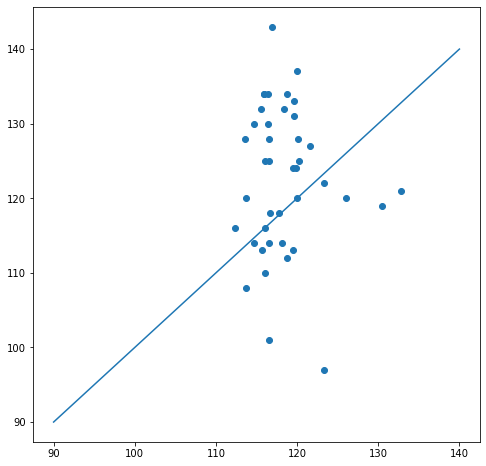

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(games_model.loc[games_model['away_team']==9,'home_score'],
           games.loc[games['away_team']=='Golden State Warriors','home_score'])

ax.plot([90,140],[90,140])

In [16]:
par_dict['ratio'] = par_dict['offense'] / par_dict['defense']

In [17]:
par_dict.sort_values(by='ratio', ascending=False)

,team,offense,defense,ratio
1,Boston Celtics,10.879372,10.364058,1.049721
5,Cleveland Cavaliers,10.375350,9.964687,1.041212
22,Philadelphia 76ers,10.660077,10.333490,1.031605
16,Milwaukee Bucks,10.865555,10.605550,1.024516
14,Memphis Grizzlies,10.819151,10.563789,1.024173
7,Denver Nuggets,10.742033,10.536109,1.019545
19,New York Knicks,10.710582,10.510289,1.019057
25,Sacramento Kings,11.160726,11.030157,1.011837
23,Phoenix Suns,10.529895,10.413279,1.011199
18,New Orleans Pelicans,10.544731,10.469742,1.007162


In [10]:
h_adv

1.0109701272460965

In [60]:
for i in range(30):
    std = np.std(games_model.loc[games_model['away_team']==i,'home_score']-\
                 games.loc[games['away_team']==par_dict.loc[i,'team'],'home_score'])
    std2 = np.std(games.loc[games['away_team']==par_dict.loc[i,'team'],'home_score'])
    print(np.round(std,3), np.round(std2,3), par_dict.loc[i,'team'])

11.215 11.504 Atlanta Hawks
10.662 11.906 Boston Celtics
13.498 14.738 Brooklyn Nets
10.039 10.699 Charlotte Hornets
12.239 12.13 Chicago Bulls
10.227 11.592 Cleveland Cavaliers
11.956 11.918 Dallas Mavericks
9.704 10.294 Denver Nuggets
10.236 11.072 Detroit Pistons
10.802 9.771 Golden State Warriors
11.624 12.91 Houston Rockets
8.749 9.9 Indiana Pacers
8.721 9.934 Los Angeles Clippers
9.121 9.975 Los Angeles Lakers
10.752 11.012 Memphis Grizzlies
10.567 10.803 Miami Heat
11.901 12.434 Milwaukee Bucks
12.648 12.859 Minnesota Timberwolves
10.107 11.185 New Orleans Pelicans
9.887 10.348 New York Knicks
11.457 11.42 Oklahoma City Thunder
10.939 11.02 Orlando Magic
11.932 13.416 Philadelphia 76ers
11.75 12.735 Phoenix Suns
10.001 10.563 Portland Trail Blazers
11.87 13.864 Sacramento Kings
11.607 11.702 San Antonio Spurs
10.278 10.538 Toronto Raptors
7.012 7.247 Utah Jazz
9.897 10.433 Washington Wizards


[[130.60643205  40.56314336]
 [ 40.56314336 136.9652647 ]]


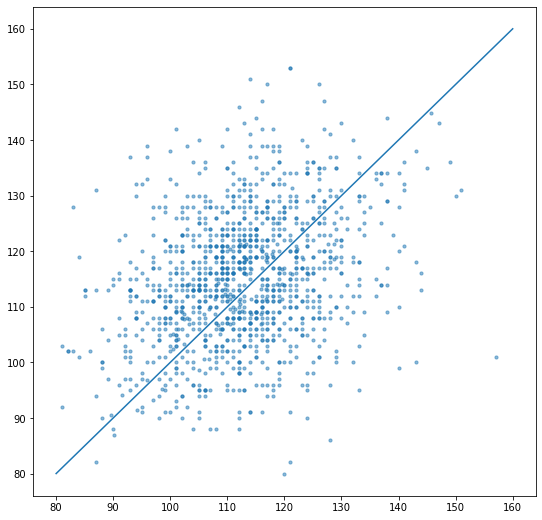

In [85]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games['away_score'] / (1.0 + games['ot']*5/48),
           games['home_score'] / (1.0 + games['ot']*5/48),
           alpha=0.5,
           s=10)

ax.plot([80,160],[80,160])

print(np.cov(games['away_score'] / (1.0 + games['ot']*5/48),
             games['home_score'] / (1.0 + games['ot']*5/48)))

[[18.3847451   3.97826657]
 [ 3.97826657 19.23782058]]


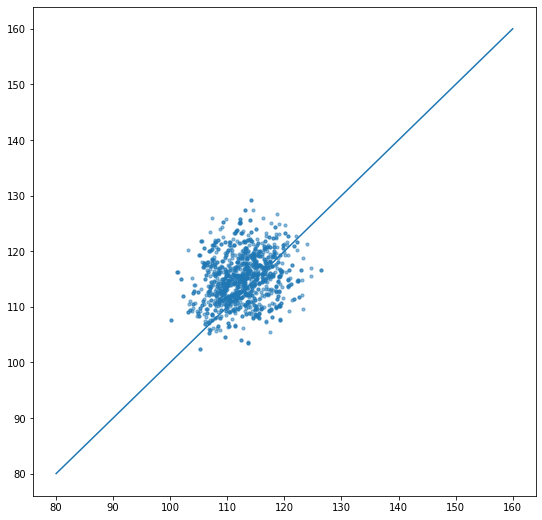

In [84]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games_model['away_score'] / (1.0 + games_model['ot']*5/48),
           games_model['home_score'] / (1.0 + games_model['ot']*5/48),
           alpha=0.5,
           s=10)

ax.plot([80,160],[80,160])

print(np.cov(games_model['away_score'] / (1.0 + games_model['ot']*5/48),
             games_model['home_score'] / (1.0 + games_model['ot']*5/48)))

[[112.37500201  36.73622232]
 [ 36.73622232 117.58587324]]


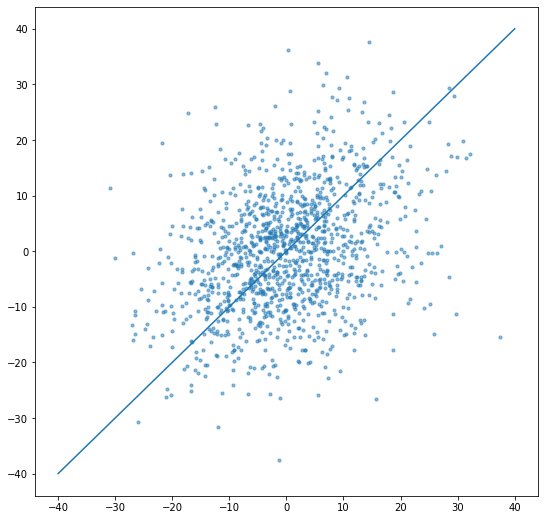

In [83]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games['away_score'] / (1.0 + games['ot']*5/48)-games_model['away_score'] / (1.0 + games_model['ot']*5/48),
           games['home_score'] / (1.0 + games['ot']*5/48)-games_model['home_score'] / (1.0 + games_model['ot']*5/48),
           alpha=0.5,
           s=10)

ax.plot([-40,40],[-40,40])

print(np.cov(games['away_score']/(1.0 + games['ot']*5/48)-games_model['away_score'] / (1.0 + games_model['ot']*5/48),
             games['home_score']/(1.0 + games['ot']*5/48)-games_model['home_score'] / (1.0 + games_model['ot']*5/48)))

In [33]:
par_dict_a, h_adv_a, games_model_a = fit_parameters(games, model_type='add')

In [34]:
h_adv_a

1.241881197451981

In [35]:
par_dict_a['diff'] = par_dict_a['offense'] - par_dict_a['defense']

In [36]:
par_dict_a.sort_values(by='diff', ascending=False)

,team,offense,defense,diff
1,Boston Celtics,59.148290,53.705531,5.442759
5,Cleveland Cavaliers,53.756936,49.455618,4.301318
22,Philadelphia 76ers,56.807328,53.369398,3.437930
16,Milwaukee Bucks,59.001271,56.261029,2.740241
14,Memphis Grizzlies,58.518155,55.813672,2.704482
7,Denver Nuggets,57.686262,55.519537,2.166725
19,New York Knicks,57.346833,55.249209,2.097625
25,Sacramento Kings,62.180780,60.770060,1.410719
23,Phoenix Suns,55.408959,54.205734,1.203225
9,Golden State Warriors,60.518092,59.736190,0.781902


In [37]:
games_model

,date,time,away_team,away_score,home_team,home_score,ot,attendance,arena
0,Tue Oct 18 2022,7:30p,22,109.282812,1,113.655168,0,19156.0,TD Garden
1,Tue Oct 18 2022,10:00p,13,116.898015,9,120.697954,0,18064.0,Chase Center
2,Wed Oct 19 2022,7:00p,21,113.689718,8,110.905670,0,20190.0,Little Caesars Arena
3,Wed Oct 19 2022,7:00p,29,117.247338,11,118.012606,0,15027.0,Gainbridge Fieldhouse
4,Wed Oct 19 2022,7:30p,10,112.541942,0,123.262171,0,17878.0,State Farm Arena
...,...,...,...,...,...,...,...,...,...
1225,Sun Apr 9 2023,3:30p,28,116.351137,13,120.422136,0,18997.0,Crypto.com Arena
1226,Sun Apr 9 2023,3:30p,18,112.569011,17,113.183840,0,18978.0,Target Center
1227,Sun Apr 9 2023,3:30p,14,116.095105,20,115.958829,0,16601.0,Paycom Center
1228,Sun Apr 9 2023,3:30p,12,107.973935,23,112.100399,0,17071.0,Footprint Center


In [38]:
games_model_a

,date,time,away_team,away_score,home_team,home_score,ot,attendance,arena
0,Tue Oct 18 2022,7:30p,22,109.270978,1,113.759569,0,19156.0,TD Garden
1,Tue Oct 18 2022,10:00p,13,116.908084,9,120.592836,0,18064.0,Chase Center
2,Wed Oct 19 2022,7:00p,21,113.803998,8,110.953508,0,20190.0,Little Caesars Arena
3,Wed Oct 19 2022,7:00p,29,117.323106,11,117.959948,0,15027.0,Gainbridge Fieldhouse
4,Wed Oct 19 2022,7:30p,10,112.641107,0,123.026675,0,17878.0,State Farm Arena
...,...,...,...,...,...,...,...,...,...
1225,Sun Apr 9 2023,3:30p,28,116.365326,13,120.314556,0,18997.0,Crypto.com Arena
1226,Sun Apr 9 2023,3:30p,18,112.572258,17,113.216287,0,18978.0,Target Center
1227,Sun Apr 9 2023,3:30p,14,116.114610,20,115.985538,0,16601.0,Paycom Center
1228,Sun Apr 9 2023,3:30p,12,107.862960,23,112.104754,0,17071.0,Footprint Center


[[112.39903509  36.70225334]
 [ 36.70225334 117.50376283]]


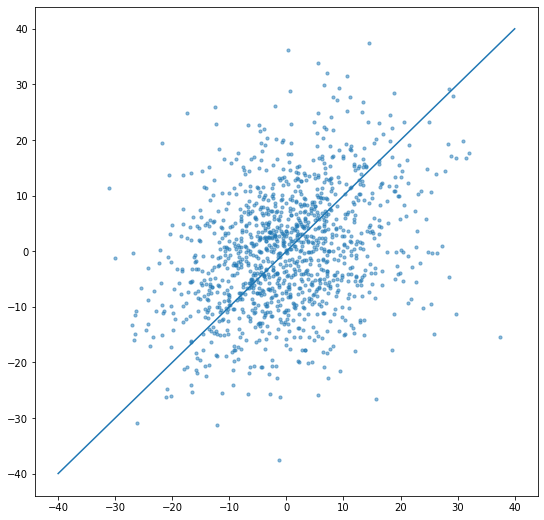

In [41]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games['away_score'] / (1.0 + games['ot']*5/48)-games_model_a['away_score'] / (1.0 + games_model_a['ot']*5/48),
           games['home_score'] / (1.0 + games['ot']*5/48)-games_model_a['home_score'] / (1.0 + games_model_a['ot']*5/48),
           alpha=0.5,
           s=10)

ax.plot([-40,40],[-40,40])

print(np.cov(games['away_score']/(1.0 + games['ot']*5/48)-games_model_a['away_score'] / (1.0 + games_model_a['ot']*5/48),
             games['home_score']/(1.0 + games['ot']*5/48)-games_model_a['home_score'] / (1.0 + games_model_a['ot']*5/48)))